In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import json
import tldextract
import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.ticker import FuncFormatter
import gensim
from gensim.parsing import PorterStemmer
import networkx as nx
from dateutil.relativedelta import relativedelta
import ast
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from ttp import ttp
p = ttp()

t_col = "#235dba"
g_col = "#005916"
c_col = "#a50808"
r_col = "#ff9900"
black = "#000000"
pink = "#f442f1"
t_ls = '-'
r_ls = '--'
c_ls = ':'
g_ls = '-.'
colors = [t_col, c_col, g_col, r_col, black, 'c', 'm', pink]
line_styles = [t_ls, r_ls, c_ls, g_ls,t_ls, r_ls, c_ls, g_ls, t_ls]

In [2]:
dataset_paths = ["../datasets/russia_052020_tweets_csv_hashed_2.csv", 
         "../datasets/russian_linked_tweets_csv_hashed.csv", 
         "../datasets/ira_tweets_csv_hashed.csv", 
         "../datasets/russia_201906_1_tweets_csv_hashed.csv"]

combined_dataset_path = "../datasets/russian_trolls.csv"

In [3]:
def get_combined_dataset(paths):
    data = pd.concat((pd.read_csv(file) for file in tqdm(paths)))
    return data

In [4]:
data = get_combined_dataset(dataset_paths)

100%|██████████| 4/4 [04:59<00:00, 74.91s/it]


  account_creation_date account_language  follower_count  following_count  \
0            2019-10-21               en            1691                1   
1            2019-10-21               en            1691                1   
2            2015-08-05               ru           17357               40   
3            2015-08-05               ru           17357               40   
4            2015-08-05               ru           17357               40   

  hashtags  in_reply_to_tweetid in_reply_to_userid  is_retweet latitude  \
0       []                  NaN                NaN       False   absent   
1       []                  NaN                NaN       False   absent   
2       []                  NaN                NaN       False   absent   
3       []                  NaN                NaN       False   absent   
4       []                  NaN                NaN       False   absent   

   like_count  ...        tweet_time              tweetid  urls  \
0        52.0  ... 

In [5]:
russians_df_all = data

In [6]:
russians_df_all.shape

(9995700, 31)

In [7]:
def get_counts_day(df, key, user_key):
    df['datetime'] = pd.to_datetime(df[key])
    df = df[[user_key,key, 'datetime']].drop_duplicates()
    print("Total Number of unique users are: ", df.shape[0])
    start_date = '2009-01-01'
    end_date = '2020-01-01'
    counts_month = df[[user_key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    return counts_month

In [8]:
def plot_days_counts_agg(list_days_and_counts, path, leg, colors, lines):
    fig, ax = plt.subplots(figsize=(12,4.5))

    k=0
    for days_and_counts in list_days_and_counts:
        counts = [x[0] for x in days_and_counts]
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        ax.plot_date(days2, counts, colors[k], linestyle=lines[k])
        k+=1

    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")     
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()

    fig.autofmt_xdate()
    plt.ylabel('# of accounts created')
    plt.grid()
    plt.xticks(rotation=40)
    plt.legend(leg, loc='best', fontsize=13)
    plt.margins(x=0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

Total Number of unique users are:  4109


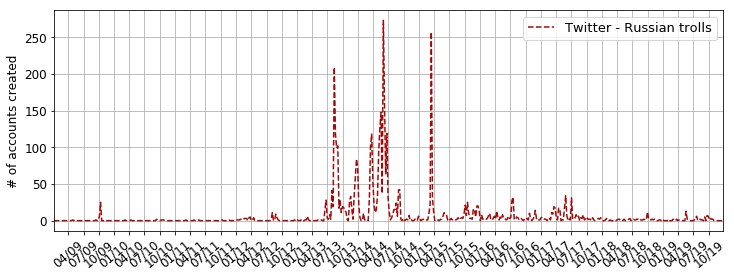

In [9]:
# russians twitter
counts_day2 = get_counts_day(russians_df_all, 'account_creation_date', 'userid')
counts_per_day2 = counts_day2['userid'].tolist()
days2 = counts_day2.index.date.tolist()
filter_days2 = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day2, days2) ]

plot_days_counts_agg([filter_days2], path='./counts_created_accounts_week_agg.pdf',
                    colors=colors[1:], lines=line_styles[1:], leg=['Twitter - Russian trolls'],)

In [10]:
print("Total number of unique users are: ", russians_df_all['userid'].nunique())

Total number of unique users are:  4109


In [11]:
russians_df_all['datetime'] = pd.to_datetime(russians_df_all['tweet_time'])

In [12]:
def get_counts_day2(df, key):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    start_date = '2012-01-01'
    end_date = '2020-01-01'
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    return counts_month

In [13]:
filter_days_all_general = []
dfs = [russians_df_all]

In [14]:
keys = ['tweetid']
for i in range(len(dfs)):
    df = dfs[i]
    k = keys[i]
    counts_day = get_counts_day2(df, k)
    counts_per_day = counts_day[k].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_days_all_general.append(filter_days[1:])

In [15]:
def plot_days_counts(days_and_counts_list, colors, lines, path, leg=False, 
                     ylabel='% of tweets'):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1
            
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.grid()
    plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

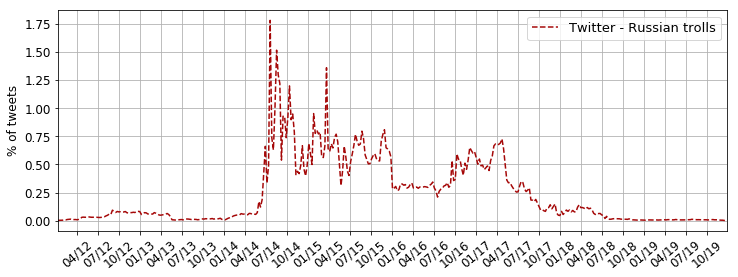

In [16]:
plot_days_counts(filter_days_all_general, colors[1:], line_styles[1:], path='./counts_per_day.pdf', 
                 leg=['Twitter - Russian trolls'])

datetimes_russian_full = russians_df_all['datetime'].tolist()
datetimes_all = [datetimes_russian_full]

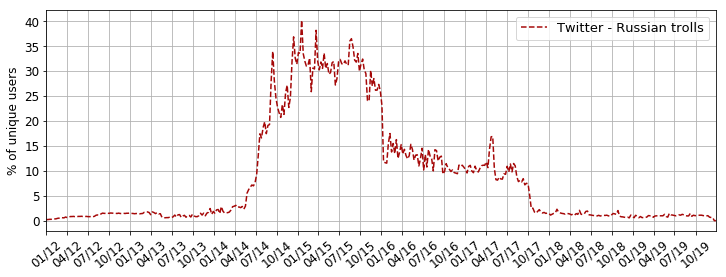

In [17]:
def get_unique_users_per_day(df, key):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w'))[key].nunique()    
    start_date = '2012-01-01'
    end_date = '2020-01-01'

    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)

    return counts_month

def plot_unique_users(days_and_counts_list, norm_counts, colors, lines, path, leg=False, ylabel='# of unique users'):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = norm_counts[k]
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1
    
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")
    
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()

    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
    plt.grid()
    plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    

dfs = [russians_df_all]
keys = ['userid']
filter_days_all = []
norms_all = []
for i in range(len(dfs)):
    df = dfs[i]
    counts_week = get_unique_users_per_day(dfs[i], keys[i])
    counts_per_week = counts_week.values
    weeks = counts_week.index
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_week, weeks) ]
    norm = len(set(df[keys[i]].tolist()))
    filter_days_all.append(filter_days)
    norms_all.append(norm)


plot_unique_users(filter_days_all, norms_all, colors[1:], line_styles[1:],
                  './unique_users_per_week.pdf', ylabel='% of unique users',
                  leg=['Twitter - Russian trolls'])

In [18]:
# extracts just the english tweets by using the language tag
is_english_tweet = russians_df_all['tweet_language'] == 'en'
english_data = russians_df_all[is_english_tweet]

In [ ]:
english_data['datetime'] = pd.to_datetime(english_data['tweet_time'])

def get_counts_day2(df, key):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    start_date = '2012-01-01'
    end_date = '2020-01-01'

    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    return counts_month

filter_days_all_general = []
dfs = [english_data]

keys = ['tweetid']
for i in range(len(dfs)):
    df = dfs[i]
    k = keys[i]
    counts_day = get_counts_day2(df, k)
    counts_per_day = counts_day[k].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_days_all_general.append(filter_days[1:])

    
def plot_days_counts(days_and_counts_list, colors, lines, path, leg=False, 
                     ylabel='% of english tweets'):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1
            
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.grid()
    plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    
plot_days_counts(filter_days_all_general, colors[1:], line_styles[1:], path='./counts_per_day_english.pdf', 
                 leg=['Twitter - Russian trolls'])

